# Анализ на положительные / негативные / нейтральные комменты. Получение тональностей комментариев

In [ ]:
!pip install transformers sentencepiece --quiet

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
file_path = 'onliner_review_dataset_test.xlsx'
data = pd.read_excel(file_path)

In [ ]:
print(data.head())
print(data.info())

  Категория                                           Товар  \
0   нотбуки             Apple Macbook Air 13" M1 2020 MGN63   
1   нотбуки              Lenovo IdeaPad 3 15ALC6 82KU00MLRK   
2   нотбуки              Lenovo IdeaPad 3 15ALC6 82KU00B3RK   
3   нотбуки     HONOR MagicBook 15 2021 BMH-WFQ9HN 53011WHD   
4   нотбуки  Machenike Star 15 S15-i512450H30504GF144LHD0BY   

                                    Заголовок отзыва  \
0                          Не рекомендую, ненадежный   
1                               Крайне не рекомендую   
2                          Ничего не предвещало беды   
3                                Экран - хуже некуда   
4  что и стоило ожидать от такого бренда, названи...   

   Оценка (количество звёзд) Комментарий к оценке  \
0                          1                 Жуть   
1                          1                 Жуть   
2                          1                 Жуть   
3                          1                 Жуть   
4                  

In [ ]:
data['Комментарий к оценке'] = data['Комментарий к оценке'].fillna('')

In [ ]:
model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

def get_sentiment(text, return_type='label'):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return model.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([-1, 0, 1])
    return proba

tokenizer_config.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [ ]:
data['Тональность'] = data['Комментарий к оценке'].apply(lambda x: get_sentiment(x, 'label'))
data['Тональность (score)'] = data['Комментарий к оценке'].apply(lambda x: get_sentiment(x, 'score'))

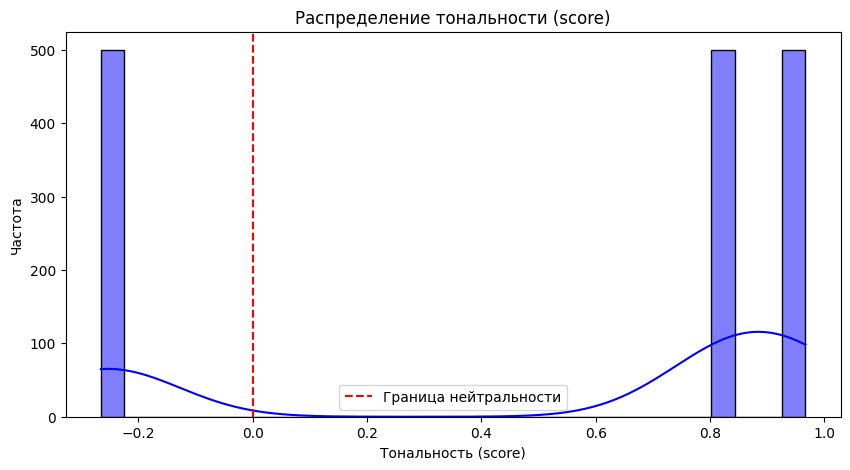

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data['Тональность (score)'], bins=30, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='dashed', label='Граница нейтральности')
plt.title('Распределение тональности (score)')
plt.xlabel('Тональность (score)')
plt.ylabel('Частота')
plt.legend()
plt.show()


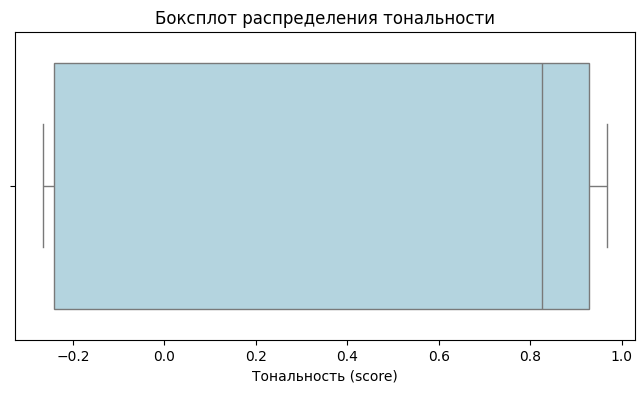

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['Тональность (score)'], color='lightblue')
plt.title('Боксплот распределения тональности')
plt.xlabel('Тональность (score)')
plt.show()


In [ ]:
output_file = 'onliner_review_analysis.xlsx'
data.to_excel(output_file, index=False)
print(f'Результаты сохранены в {output_file}')

Результаты сохранены в onliner_review_analysis.xlsx


#Получение эмбеддингов

In [ ]:
from transformers import AutoTokenizer, AutoModel

In [ ]:
# Загрузка модели для эмбеддингов

embedding_model = AutoModel.from_pretrained(model_checkpoint)
embedding_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

if torch.cuda.is_available():
    embedding_model.cuda()

def get_embedding(text):
    with torch.no_grad():
        inputs = embedding_tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(embedding_model.device)
        outputs = embedding_model(**inputs)
        # Получение CLS-токена как представление текста
        cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return cls_embedding.flatten()

data['Эмбеддинг'] = data['Комментарий к оценке'].apply(get_embedding)

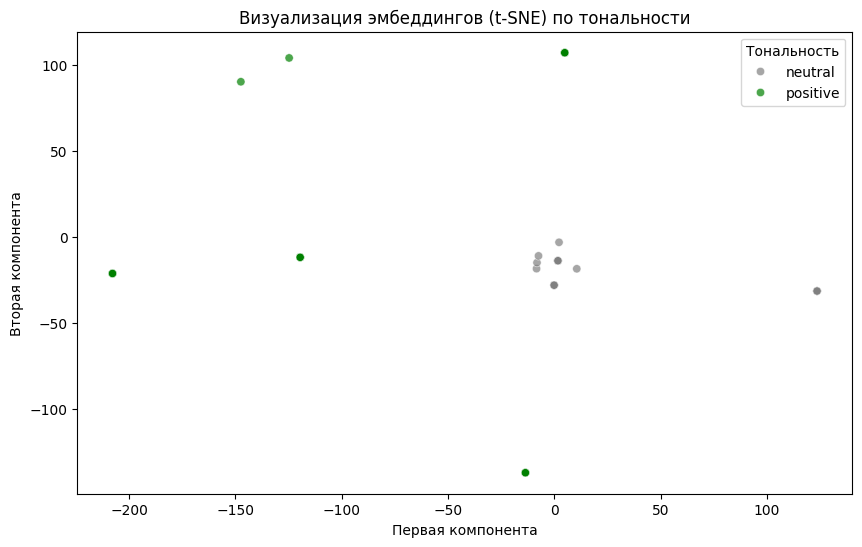

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Преобразование списка эмбеддингов в numpy массив
embeddings = np.vstack(data['Эмбеддинг'].values)

# Уменьшаем размерность до 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Создадим цветовую разметку на основе тональности
labels = data['Тональность']
colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
color_labels = [colors[label] for label in labels]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette=colors, alpha=0.7)
plt.title('Визуализация эмбеддингов (t-SNE) по тональности')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.legend(title="Тональность")
plt.show()


# Кластеризация комментариев с помощью эмбеддингов

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

In [ ]:
# Матрица эмбеддингов
embeddings_matrix = np.stack(data['Эмбеддинг'].values)

# Метод локтя для выбора числа кластеров
def find_optimal_clusters(data, max_k=10):
    distortions = []
    silhouette_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    return distortions, silhouette_scores

distortions, silhouette_scores = find_optimal_clusters(embeddings_matrix)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:

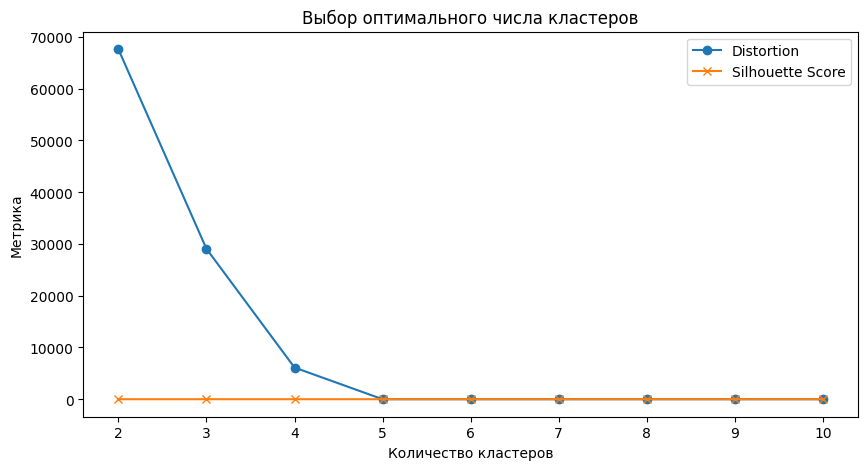

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(2, len(distortions)+2), distortions, marker='o', label='Distortion')
plt.plot(range(2, len(silhouette_scores)+2), silhouette_scores, marker='x', label='Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Метрика')
plt.legend()
plt.title('Выбор оптимального числа кластеров')
plt.show()

In [ ]:
# Кластеризация
optimal_clusters = 5  # На основе графика
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Кластер'] = kmeans.fit_predict(embeddings_matrix)

In [ ]:
for cluster in range(optimal_clusters):
    print(f"\nКластер {cluster}:")
    cluster_comments = data[data['Кластер'] == cluster]['Недостатки'].sample(30)
    print(cluster_comments.tolist())


Кластер 0:
['Отвратительный звук.', 'Отжим! нужно закладывать побольше вещей (не превышая max конечно)', 'огромные лаги', 'Постоянно горит экран. Греется.', 'Сделан из фольги. Слабая краска. Очень слабый пластик', 'звук; при неполной загрузке отжимает плохо', 'возраст', 'Заела дверца в первый же день нашей совместной жизни', 'IOS, Lighting, нет блока питания в комплекте, 60 Гц.', 'Баги в ПО с Блютузом!!!', 'Малая ёмкость пылесборника, часто забиваются фильтры пылесоса, нет регулировки мощности всасывания.', 'IPS - боль; Рамки; Уже никогда не найдёшь в РБ оригинальных чехлов, и довольствуйся противными китайскими чехлами с алика; Комплектация', 'Датчик приближение работает не корректно, подтупливает.', 'Программная часть (особенно невозможность ответа на сообщения).Завышенная цена.', 'Сенсор', 'Экран, проблемы с поиском и установкой драйверов в случае смены операционной системы. Клавиатура на любителя', 'Треснутый дисплей с завода,что с ним будет дальше,не известно...', 'качество уборк

In [ ]:
output_file_clusters = 'onliner_review_with_clusters.xlsx'
data.drop('Эмбеддинг', axis=1).to_excel(output_file_clusters, index=False)
print(f'Результаты кластеризации сохранены в {output_file_clusters}')

Результаты кластеризации сохранены в onliner_review_with_clusters.xlsx


# Использование LLM

In [ ]:
!pip install transformers
!pip install torch
!pip install nncf optimum[openvino]

In [ ]:
from optimum.intel.openvino import OVModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer

# Загрузка модели и токенайзера
model_id = "MTSAIR/Cotype-Nano-CPU"
model = OVModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)


openvino_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/2.89M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
from optimum.intel.openvino import OVModelForCausalLM
from transformers import AutoTokenizer, pipeline
import time

model_id = "MTSAIR/Cotype-Nano-CPU"
model = OVModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_length=2048, device="cpu")

messages = [
  {"role": "user", "content": "Расскажи мне про ИИ"},
]

results = pipe(messages)
print(results)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


config.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/2.89M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

[{'generated_text': [{'role': 'user', 'content': 'Расскажи мне про ИИ'}, {'role': 'assistant', 'content': 'Конечно, расскажу! Искусственный интеллект (ИИ) – это область информатики и искусственного интеллекта, которая занимается созданием систем, способных выполнять задачи, требующие человеческого интеллекта. Вот несколько ключевых моментов:\n\n1. **Определение ИИ**:\n   - Существует множество определений ИИ, но одно из них заключается в том, что это "системы, которые могут выполнять задачи, требующие человеческого мышления".\n\n2. **Типы ИИ**:\n   - *Специализированный ИИ* (или традиционный ИИ): разрабатывается для конкретной задачи.\n   - *Общественный ИИ*: разрабатывается с целью имитировать поведение человека или группу людей.\n\n3. **Основные аспекты**:\n   - Обучение (на основе данных).\n   - Непрерывное обучение (самообучение).\n   - Оценка качества работы системы.\n\n4. **Применения ИИ**:\n   - Автоматизация рут сфер: от робототехники до банковских технологий.\n   - Вопросами п

In [ ]:
# Пример кластеров и комментариев
clusters = {
    0: [
        'Звук',
        'Сканер отпечатков, отсутствие датчика приближения, слабый сигнал Wi-Fi, косяки в ПО, камеры-заглушки, царапающийся блок камеры об воздух, шумоподавление.',
        'Выше',
        'Гулкий бас, слабые верхи, цена, короткие провода',
        'Наводки в колонках, провода, современная цена.',
        'Абсолютно неточно показывают активность (очень завышают)',
        'Качество', 'Нужно знать китайский, чтобы пользоваться.',
        'Экран ярковат. Пришлось заклеить. 1 из 3х тесовых отключений не сработал. ( что печально) Софт не рабочий.',
        'Нет зарядки в комплекте. Хотя бы переходник положили typ c- usb Отпечаток пальцев нет',
        'Нельзя назначать или запрещать зону,слабая батарея, никакая влажная уборка,туповат.',
        'отсутствия записи звонков, большой дисплей',
        'греется очень, слабо тянет',
        'ТЭН - рекламный PR ход.',
        'Звук при прослушивании музыки (через наушники в том числе) резкий; а кино смотреть - нормальный. Задняя крышка неплотно приклеена сверху.',
        'Неадекватная цена, широченная челка из-за которой статус бар почти отсутствует, iOs устарела и теперь сильно проигрывает андроиду'
    ],

    1: [
        'Нет ощущения дороговизны и топовости, нет адаптера в комплекте',
        'Процессор.',
        'бьется током слабоват герметичность шланга',
        'Тормоз, завышенная ценность, просто худший.',
        'Качество сборки. Качество материалов. Нет ощущение надежности. Первый дефект обнаружен через 3 месяца. Дурацкая музыка по завершении стирки.',
        'Древний дизайн, "кнопка", нет ночного режима камеры(хоть и процессор позволяет с запасом), нет ручных настроек камеры, древняя матрица.',
        'От малейшей влаги умирают, и, к сожалению, это у всей линейки так.',
        'Выпирающая камера все таки напрягает',
        'Надежность, запланированное устаревание',
        'датчик приближения и размер',
        'камера',
        '- быстро сломалась функция оценки тела',
        'Батарея долго не держит, лучшие игры крайне дороги, необходима карта памяти, слабый приемник вай-фай',
        'Камеры нет!!!!',
        'Камера, экран, проблемы ПО, ужасная тех. поддержка'
    ],

    2: [
        'Такое ощущение что купил демо версию смартфона, а не готовый продукт.',
        'короткий шнур -шумный -фильтр воняет -китайские щетки -тяжелый -слабо всасывает пыль - чрезмерная мощность',
        'срок службы - 10 дней 50%/50%, что потечет сразу после истечения гарантии',
        'Экран',
        'Очень Слабая тяга Плохое качество сборки и пластмассы Щетка сломалась сразу же Вытряхивать контейнер неудобно Шнур короткий Все кал.',
        'Очень сильно шумит, особенно с защитой на вентиляторе.',
        '3.5 не греет ничего.',
        'Качество сборки, качество материалов, вода в уплотнении, на деле никакого гарантийного обслуживания.',
        'Год работы без ремонта его предел',
        'Отказался работать на восьмом дне использования.',
        'Быстро царапается экран, медленные порты type C, быстрый износ батареи, легко получить кирпич при сбросе настроек до заводских, сильно греется',
        'камера камера камера',
        'неудобство в использовании, см.выше.',
        'Цена. Камера. Шим.',
        'Это не телефон.. Не берите даже, для простейших задач..'
    ],

    3: [
        'Жирный минус - камера Низкое качество воспроизведения музыки Не очень громкий звук вызова',
        'плохой экран',
        'Недостатки:Маленький объем оперативки, отсутствие автоматической настройки яркости.',
        'Маленький размер экрана. Нет радио Полностью стеклянный телефон. Если падает быстро разбивается. Дорогой ремонт. Наушники не очень по звучанию. Вот.',
        'Экран, лаги в оболочке, цена.',
        'Нет подсветки кнопок. Не удобно расположены динамики. Не корректная работа автоматической яркости (зато бережёт зрение).',
        'Bug sur еще полнится не критичными багами, рамки экрана толстые для 2021 года. Веб камера дно.',
        'Камера, сервисы хуавей, попался бракованный',
        'Нет ночного режима не ультраширике и фронталке',
        'надёжность оставляет желать лучшего',
        'Цена',
        'Краска мажет пальцы Немного тормозит интерфейс Мало оперативы',
        'Отсутствие слота для карты памяти',
        'экран',
        'Шум -Внешний вид'
    ],

    4: [
        'Хотелось бы батарею побольше емкостью, но это скорее просто пожелание, а не недостаток.',
        'Довольно тяжелый. Сложности с покупкой стилуса под этот планшет',
        'Яркость экрана маловата',
        'нет черного цвета корпуса',
        'Возможно, стоило разместись порты по разным сторонам корпуса',
        'Не нашел.',
        'Нет дискретной видеокарты, но это не тот ценовой сегмент',
        '-большая зарядка, портит все плюсы миниатюрности ультрабука -нету type-c -маркий корпус -кому-то будет минус отсутствие веб-камеры',
        'Нету',
        'Звук',
        'хотелось бы на карте 3080 модельку за те же деньги))',
        'шрифт на клавиатуре может кого-то не устроить (маленькие буквы русские, большие английские изменённым шрифтом) но это прям если дакапываться.',
        'После обновления ОС до ОС Монтерей стал хуже держаться заряд, надеюсь исправят при следующем обновлении ОС',
        'Для себя не нашел.',
        'пока не заметил'
    ]
}


In [ ]:
from optimum.intel.openvino import OVModelForCausalLM
from transformers import AutoTokenizer, pipeline

model_id = "MTSAIR/Cotype-Nano-CPU"
model = OVModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Создание пайплайна для генерации текста
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_length=2048, device="cpu", truncation=True)


# Функция для анализа одного кластера
def analyze_cluster(cluster_id, comments):
    prompt = (
        f"На основе следующих отзывов определи основную проблему, объясни её и предоставь анализ в строго следующем формате:\n"
        f"1. Основная проблема: [опиши проблему одной фразой]\n"
        f"2. % соотношение по встречаемости: [укажи процент встречаемости основной проблемы среди всех отзывов]\n"
        f"3. Топ 5 комментов по основной проблеме:\n"
        f"   1) [первый комментарий]\n"
        f"   2) [второй комментарий]\n"
        f"   3) [третий комментарий]\n"
        f"   4) [четвертый комментарий]\n"
        f"   5) [пятый комментарий]\n"
        f"4. Краткий вывод: [объясни, почему эта проблема важна, и как она влияет на пользователей].\n\n"
        f"Отзывы:\n" + "\n".join(comments)
    )
    result = pipe(prompt)[0]["generated_text"]
    return result

In [ ]:
# Анализ всех кластеров
for cluster_id, comments in clusters.items():
    print(f"\n=== Анализ для кластера {cluster_id} ===")
    result = analyze_cluster(cluster_id, comments)
    print(result)


=== Анализ для кластера 0 ===
На основе следующих отзывов определи основную проблему, объясни её и предоставь анализ в строго следующем формате:
1. Основная проблема: [опиши проблему одной фразой]
2. % соотношение по встречаемости: [укажи процент встречаемости основной проблемы среди всех отзывов]
3. Топ 5 комментов по основной проблеме:
   1) [первый комментарий]
   2) [второй комментарий]
   3) [третий комментарий]
   4) [четвертый комментарий]
   5) [пятый комментарий]
4. Краткий вывод: [объясни, почему эта проблема важна, и как она влияет на пользователей].

Отзывы:
Звук
Сканер отпечатков, отсутствие датчика приближения, слабый сигнал Wi-Fi, косяки в ПО, камеры-заглушки, царапающийся блок камеры об воздух, шумоподавление.
Выше
Гулкий бас, слабые верхи, цена, короткие провода
Наводки в колонках, провода, современная цена.
Абсолютно неточно показывают активность (очень завышают)
Качество
Нужно знать китайский, чтобы пользоваться.
Экран ярковат. Пришлось заклеить. 1 из 3х тесовых отк